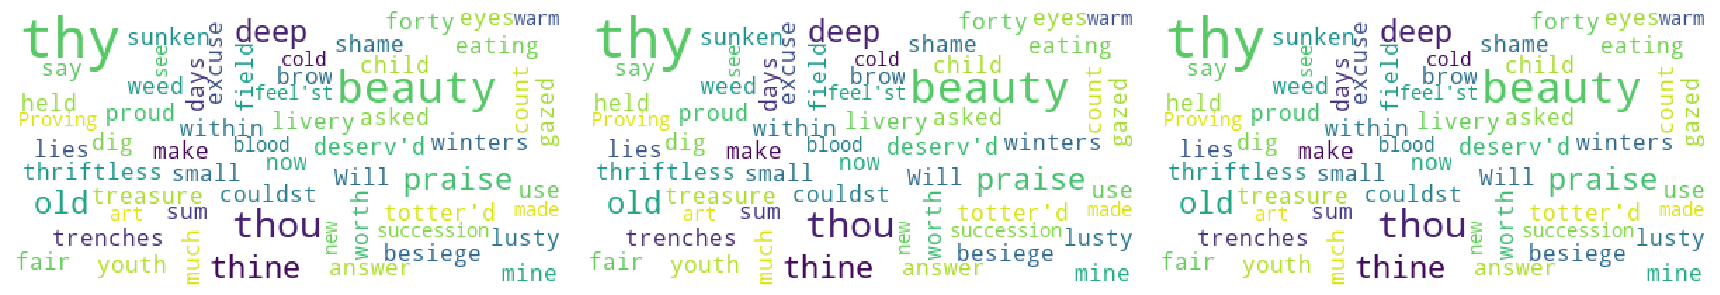

In [1]:
import re
import numpy as np
import string
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
data ="""When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold."""

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=42
                         ).generate(data)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 24))
axes[0].imshow(wordcloud)
axes[0].axis('off')
axes[1].imshow(wordcloud)
axes[1].axis('off')
axes[2].imshow(wordcloud)
axes[2].axis('off')
fig.tight_layout()

<h1 id="definition" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Definition
        <a class="anchor-link" href="#definition" target="_self">¶</a>
    </center>
</h1>

Word embeddings are dense vectors of real numbers, one per word in your vocabulary. In NLP, it is almost always the case that your features are words! But how should you represent a word in a computer? You could store its ascii character representation, but that only tells you what the word is, it doesn’t say much about what it means (you might be able to derive its part of speech from its affixes, or properties from its capitalization, but not much). Even more, in what sense could you combine these representations? We often want dense outputs from our neural networks, where the inputs are |V| dimensional, where V is our vocabulary, but often the outputs are only a few dimensional (if we are only predicting a handful of labels, for instance)

<h1 id="dataset" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Dataset
        <a class="anchor-link" href="#dataset" target="_self">¶</a>
    </center>
</h1>

In [2]:
sentences = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold."""

### Prepare data

In [3]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

### Prepare the dictionaries

In [4]:
# list of words
words = sentences.split()

# get vocabulary (set(words)) - unique words
vocab = set(words)

In [5]:
# word to id
word_to_ix = {w: i for i, w in enumerate(vocab)}

# id to word
ix_to_word = {i: w for i, w in enumerate(vocab)}

In [6]:
word_to_ix['the']

21

In [7]:
ix_to_word[83]

'made'

<h1 id="prepare" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Embeddings and Trigrams
        <a class="anchor-link" href="#prepare" target="_self">¶</a>
    </center>
</h1>

### Prepare the embeddings matrix

In [8]:
vocab_size = len(set(vocab))
embedding_dimension = 10

In [9]:
#embedding matrix = vocabulary_size x embedding_dimension
embeddings =  np.random.random_sample((vocab_size, embedding_dimension))

### Input/Targets

In [10]:
trigrams = [([words[i], words[i+1]], words[i+2]) for i in range(len(words) - 2)]

In [11]:
# inputs = ['word1', 'word2']
# targets = 'target'
# ( ['word1', 'word2'], 'target')
trigrams[0]

(['when', 'forty'], 'winters')

<h1 id="implementation" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Implementation
        <a class="anchor-link" href="#implementation" target="_self">¶</a>
    </center>
</h1>

### Activation functions

In [12]:
def relu(x):
    return x * (x > 0)

def drelu(x):
    return 1. * (x > 0)

In [13]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

### Loss function

In [14]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

### Linear models

In [15]:
def linear1(x, theta):
    w1, w2 = theta
    return np.dot(x, w1.T)

def linear2(o, theta):
    w1, w2 = theta
    return np.dot(o, w2.T)

### Forward function

In [16]:
def forward(x, theta):
    m = embeddings[x].reshape(1, -1)
    n = linear1(m, theta)
    o = relu(n)
    p = linear2(o, theta)
    q = log_softmax(p)
    
    params = m, n, o, p, q
    return(params)

### Log-Softmax Cross-Entropy

Cross Entropy = NLLoss(log_softmax(p))

We could also say that Cross Entropy is NLLoss + log_softmax

In [17]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]

### Backward function

In [18]:
def backward(x, y, theta, params):
    m, n, o, p, q = params
    w1, w2 = theta
    
    dlog = log_softmax_crossentropy_with_logits(p, y)
    drelu = relu(n)
    
    # dw2 = dlog * o
    do = np.dot(dlog,w2)
    dw2 = np.dot(dlog.T, o)
    
    # dw1 = do * drelu * m
    dn = do * drelu
    dw1 = np.dot(dn.T, m)
    
    return dw1, dw2

### Optimizer function

In [19]:
def optimize(theta, grads, lr=0.03):
    w1, w2 = theta
    dw1, dw2 = grads
    
    w1 -= dw1 * lr
    w2 -= dw2 * lr
    
    return theta

<h1 id="training" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Training
        <a class="anchor-link" href="#training" target="_self">¶</a>
    </center>
</h1>

In [20]:
theta = np.random.uniform(-1,1, (128, 20)), np.random.uniform(-1,1, (85, 128))

In [21]:
context, target  = trigrams[0]

In [22]:
# convert context('word1', 'word2') into [#1, #2] word to ix
context_ix = [word_to_ix[c] for c in context]

# convert to numpy array and convert from (2,) to (1,2)
context_ix = np.array(context_ix)
context_ix = context_ix.reshape(1, 2)

# forward propagation (predict)
params = forward(context_ix, theta)

# get the looses and append to epoch losses
loss = NLLLoss(params[-1], [word_to_ix[target]])

# get the gradients from back propagation
grads = backward(context_ix, [word_to_ix[target]], theta, params)

In [23]:
params[-2].shape

(1, 85)

In [24]:
[word_to_ix[target]]

[19]

In [25]:
log_softmax_crossentropy_with_logits(params[-2], [word_to_ix[target]])

array([[ 3.44425938e-05,  1.20464159e-03,  2.06585988e-03,
         1.15666654e-04,  2.44028406e-02,  9.83153655e-05,
         7.91231529e-08,  6.40974123e-09,  2.06069825e-02,
         1.94089590e-03,  7.08210619e-05,  3.31239070e-04,
         4.83328435e-04,  6.20929343e-08,  4.33553394e-07,
         4.28798331e-06,  1.14572380e-05,  9.91350113e-06,
         2.25797539e-06, -9.96622665e-01,  1.87675871e-03,
         2.77560519e-05,  1.44803850e-03,  6.87762436e-04,
         3.21750933e-07,  1.77587542e-01,  9.26547822e-06,
         1.51305771e-01,  2.39534829e-04,  2.98019100e-06,
         4.99228976e-03,  4.05648951e-03,  1.57456214e-03,
         2.01077465e-07,  2.22354874e-05,  8.29660324e-06,
         3.96445121e-06,  6.73704104e-02,  1.81207985e-03,
         4.27670177e-02,  7.47426641e-04,  7.33676933e-06,
         8.70280774e-05,  8.71657302e-05,  4.34118404e-04,
         1.25036716e-07,  8.90992255e-05,  2.86786201e-03,
         1.34479551e-06,  8.11484403e-07,  4.20333289e-0

In [26]:
losses = {}

for epoch in range(1000):

    epoch_losses = []
    
    for context, target in trigrams:
        
        # convert context('word1', 'word2') into [#1, #2] word to ix
        context_ix = [word_to_ix[c] for c in context]

        # convert to numpy array and convert from (2,) to (1,2)
        context_ix = np.array(context_ix)
        context_ix = context_ix.reshape(1, 2)

        # forward propagation (predict)
        params = forward(context_ix, theta)

        # get the looses and append to epoch losses
        loss = NLLLoss(params[-1], [word_to_ix[target]])
        epoch_losses.append(loss)

        # get the gradients from back propagation
        grads = backward(context_ix, [word_to_ix[target]], theta, params)

        # optimize the weights Stochastic gradient descent (SGD)
        theta = optimize(theta, grads)
        
    losses[epoch] = epoch_losses

<h1 id="analyze" style="color:#1f9f88; background:white; border:0.5px dotted;"> 
    <center>Analyze
        <a class="anchor-link" href="#analyze" target="_self">¶</a>
    </center>
</h1>

### Plot losses

Text(0, 0.5, 'Losses')

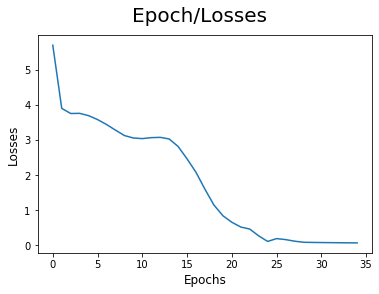

In [27]:
ix = np.arange(0,35)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

### Predict function

In [28]:
def predict(words):
    context_ix = [word_to_ix[c] for c in words]
    params = forward(context_ix, theta)
    word = ix_to_word[np.argmax(params[-1])]
    
    return word

### Test prediction

In [29]:
# 'And dig deep trenches in thy beauty's field'
# expected answer 'deep'
predict(["and", "dig"])

'deep'

In [30]:
def accuracy():
    wrong = 0

    for context, target in trigrams:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(trigrams)))

In [31]:
accuracy()

0.9649122807017544

Accuracy of 96.49%, please don't forget to up-vote if you enjoy it :)

If you want to learn more about this integration, read more on this pytorch tutorial:<br>
https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html